# Basic data analysis

You will learn how to **combine** (join and concatenate) datasets, **download online datasets** (through an API), and use **split-apply-combine** to calculate group-level statistics and make group-level plots.


In [1]:
import numpy as np
import pandas as pd
import datetime

import pandas_datareader # install with `pip install pandas-datareader`
import pydst # install with `pip install git+https://github.com/elben10/pydst`

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib_venn import venn2 # `pip install matplotlib-venn`

C:\Users\gmf123\Anaconda3\envs\new\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


# Combining datasets (merging and concatenating)

When **combining datasets** there are a few crucial concepts: 

1. **Concatenate (append)**: "stack" rows (observations) on top of each other. This works if the datasets have the same columns (variables).
2. **Merge**: the two datasets have different variables, but may or may not have the same observations. 

There are **different kinds of merges** depending on which observations you want to keep:

1. **Outer join (one-to-one)** Keep observations which are in *either* or in *both* datasets.
2. **Inner join (one-to-one)** Keep observations which are in *both* datasets. 
3. **Left join (many-to-one)** Keep observations which are in the *left* dataset or in *both* datasets. 

Keeping observations which are not in both datasets will result in **missing values** for the variables comming from the dataset, where the observation does not exist.

**Read data:**

In [2]:
empl = pd.read_csv('../07/data/RAS200_long.csv') # .. -> means one folder up
inc = pd.read_csv('../07/data/INDKP107_long.csv')
area = pd.read_csv('../07/data/area.csv')

## Concatenating datasets

Suppose we have two datasets that have the same variables and we just want to concatenate them. 

In [3]:
empl.head(5)

,municipality,year,e
0,Copenhagen,2008,72.5
1,Frederiksberg,2008,75.6
2,Dragør,2008,80.5
3,Tårnby,2008,79.0
4,Albertslund,2008,73.1


In [4]:
N = empl.shape[0]
A = empl.loc[empl.index < N/2,:] # first half of observations
B = empl.loc[empl.index >= N/2,:] # second half of observations

print(f'A has shape {A.shape} ')
print(f'B has shape {B.shape} ')

A has shape (495, 3) 
B has shape (495, 3) 


**Concatenation** is done using the command `pd.concat([df1, df2])`. 

In [5]:
C = pd.concat([A,B])
print(f'C has shape {C.shape} (same as the original empl, {empl.shape})')

C has shape (990, 3) (same as the original empl, (990, 3))


## Merging datasets

Two datasets with **different variables**: `empl` and `inc`. 

**Central command:** `pd.merge(empl, inc, on=[municipalitiy, year], how=METHOD)`. 

1. The keyword `on` specifies the **merge key(s)**. They uniquely identify observations in both datasets (for sure in at least one of them).  

2. The keyword `how` specifies the **merge method** (taking values such as `'outer'`, `'inner'`, or `'left'`).

**Look at datasets:**

In [6]:
print(f'Years in empl: {empl.year.unique()}')
print(f'Municipalities in empl = {len(empl.municipality.unique())}')
print(f'Years in inc: {inc.year.unique()}')
print(f'Municipalities in inc = {len(inc.municipality.unique())}')

Years in empl: [2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
Municipalities in empl = 99
Years in inc: [2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
Municipalities in inc = 98


**Find differences:**

In [7]:
diff_y = [y for y in inc.year.unique() if y not in empl.year.unique()] 
print(f'years in inc data, but not in empl data: {diff_y}')

diff_m = [m for m in empl.municipality.unique() if m not in inc.municipality.unique()] 
print(f'municipalities in empl data, but not in inc data: {diff_m}')

years in inc data, but not in empl data: [2004, 2005, 2006, 2007]
municipalities in empl data, but not in inc data: ['Christiansø']


**Conclusion:** `inc` has more years than `empl`, but `empl` has one municipality that is not in `inc`. 

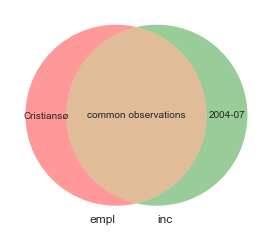

In [8]:
plt.figure()
v = venn2(subsets = (4, 4, 10), set_labels = ('empl', 'inc'))
v.get_label_by_id('100').set_text('Cristiansø')
v.get_label_by_id('010').set_text('2004-07' )
v.get_label_by_id('110').set_text('common observations')
plt.show()

### Outer join: union

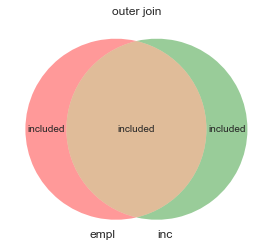

In [9]:
plt.figure()
v = venn2(subsets = (4, 4, 10), set_labels = ('empl', 'inc'))
v.get_label_by_id('100').set_text('included')
v.get_label_by_id('010').set_text('included')
v.get_label_by_id('110').set_text('included')
plt.title('outer join')
plt.show()

In [10]:
outer = pd.merge(empl,inc,on=['municipality','year'],how='outer')

print(f'Number of municipalities = {len(outer.municipality.unique())}')
print(f'Number of years = {len(outer.year.unique())}')

Number of municipalities = 99
Number of years = 14


We see that the **outer join** includes rows that exist in either dataframe and therefore includes missing values:

In [11]:
I = (outer.year.isin(diff_y)) | (outer.municipality.isin(diff_m))
outer.loc[I, :].head(15)

,municipality,year,e,inc
29,Christiansø,2008,62.9,NaN
128,Christiansø,2009,64.6,NaN
227,Christiansø,2010,67.8,NaN
326,Christiansø,2011,67.7,NaN
425,Christiansø,2012,69.6,NaN
524,Christiansø,2013,69.4,NaN
623,Christiansø,2014,70.0,NaN
722,Christiansø,2015,75.5,NaN
821,Christiansø,2016,77.8,NaN
920,Christiansø,2017,80.9,NaN


### Inner join

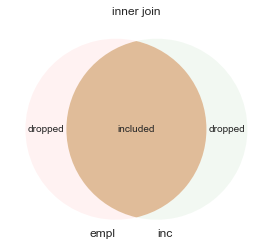

In [12]:
plt.figure()
v = venn2(subsets = (4, 4, 10), set_labels = ('empl', 'inc'))
v.get_label_by_id('100').set_text('dropped'); v.get_patch_by_id('100').set_alpha(0.05)
v.get_label_by_id('010').set_text('dropped'); v.get_patch_by_id('010').set_alpha(0.05)
v.get_label_by_id('110').set_text('included')
plt.title('inner join')
plt.show()

In [13]:
inner = pd.merge(empl,inc,how='inner',on=['municipality','year'])

print(f'Number of municipalities = {len(inner.municipality.unique())}')
print(f'Number of years          = {len(inner.year.unique())}')

Number of municipalities = 98
Number of years          = 10


We see that the **inner join** does not contain any rows that are not in both datasets. 

In [14]:
I = (inner.year.isin(diff_y)) | (inner.municipality.isin(diff_m))
inner.loc[I, :].head(15)

,municipality,year,e,inc


### Left join

In my work, I most frequently use the **left join**. It is also known as a *many-to-one* join. 

* **Left dataset:** `inner` many observations of a given municipality (one per year),
* **Right dataset:** `area` at most one observation per municipality and new variable (km2). 

In [15]:
inner_with_area = pd.merge(inner, area, on='municipality', how='left')
inner_with_area.head(5)

,municipality,year,e,inc,km2
0,Copenhagen,2008,72.5,259216.0,86.7
1,Frederiksberg,2008,75.6,296988.0,8.7
2,Dragør,2008,80.5,371290.0,18.3
3,Tårnby,2008,79.0,288973.0,66.1
4,Albertslund,2008,73.1,269855.0,23.4


In [16]:
print(f'inner has shape {inner.shape}')
print(f'area has shape {area.shape}')
print(f'merge result has shape {inner_with_area.shape}')

inner has shape (980, 4)
area has shape (99, 2)
merge result has shape (980, 5)


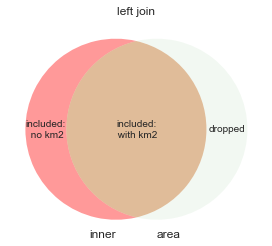

In [17]:
plt.figure()
v = venn2(subsets = (4, 4, 10), set_labels = ('inner', 'area'))
v.get_label_by_id('100').set_text('included:\n no km2'); 
v.get_label_by_id('010').set_text('dropped'); v.get_patch_by_id('010').set_alpha(0.05)
v.get_label_by_id('110').set_text('included:\n with km2')
plt.title('left join')
plt.show()

**Intermezzo:** Finding the non-overlapping observations

In [18]:
not_in_area = [m for m in inner.municipality.unique() if m not in area.municipality.unique()]
not_in_inner = [m for m in area.municipality.unique() if m not in inner.municipality.unique()]

print(f'There are {len(not_in_area)} municipalities in inner that are not in area. They are:')
print(not_in_area)
print('')

print(f'There is {len(not_in_inner)} municipalities in area that are not in inner. They are:')
print(not_in_inner)
print('')

There are 0 municipalities in inner that are not in area. They are:
[]

There is 1 municipalities in area that are not in inner. They are:
['Christiansø']



**Check that km2 is never missing:**

In [19]:
inner_with_area.km2.isnull().mean()

0.0

### Alternative function for left joins: `df.join()`

To use a left join function `df.join()`, we must first set the index. Technically, we do not need this, but if you ever need to join on more than one variable, `df.join()` requires you to work with indices so we might as well learn it now. 

In [20]:
inner.set_index('municipality', inplace=True)
area.set_index('municipality', inplace=True)
final = inner.join(area)
print(f'final has shape: {final.shape}')
final.head(5)

final has shape: (980, 4)


,year,e,inc,km2
municipality,,,,
Aabenraa,2008,74.6,308611.0,940.7
Aabenraa,2009,71.6,308226.0,940.7
Aabenraa,2010,70.9,350112.0,940.7
Aabenraa,2011,70.2,346564.0,940.7
Aabenraa,2012,69.5,349133.0,940.7


## Other programming languages 

**SQL** (including SAS *proc sql*)

SQL is one of the most powerful database languages and many other programming languages embed a version of it. For example, SAS has the `proc SQL`, where you can use SQL syntax. 

SQL is written in statements such as 

* **left join**   `select * from empl left join inc on empl.municipality = inc.municipality and empl.year = inc.year`
* **outer join** `select * from empl full outer join inc on empl.municipality = inc.municipality and empl.year = inc.year`

**STATA**

In Stata, the command `merge` nests many of the commands mentioned above. You specify `merge 1:1`  for a one-to-one merge or `merge m:1`  or `merge 1:m`  for many-to-one or one-to-many merges, and you do not use `merge m:m` (until you are quite advanced). 

# Fetching data using an API

API stands for **Application Programming Interface**. An API is an interface through which we can directly ask for and **receive data from an online source**. We will be using packages for this and will not look at what is going on underneath. 

1. We use `pandas_datareader` to access many common **international online data** sources (install with `pip install pandas-datareader`)
2. For **Statistics Denmark**, Jakob Elben has written the `pydst` package (install with `pip install git+https://github.com/elben10/pydst`)

Fetching data from an API requires an **internet connection** and works directly without saving data to your hard disc (unless you ask Python to do so afterwards). You can use it to automate tasks such as fetching the most recent data, doing some calculations and outputting it in the same manner. This can be useful e.g. for quarterly reports. 

**Pros:** Automatic; smart; everything is done from Python (so no need to remember steps in between). 

**Cons:** The connection can be slow or drop out, which may lead to errors. If e.g. 100 students simultaneously fetch data (during, say, a lecture), the host server may not be able to service all the requests and may drop out. 

> The raw output data from an API could look like this: https://stats.oecd.org/SDMX-JSON/data/NAAG. It is a log list of non-human-readable gobledygook in the so-called "JSON" format. 

## Import data from Denmark Statistics

**Setup:**

In [21]:
Dst = pydst.Dst(lang='en') # setup data loader with the langauge 'english'

Data from DST are organized into: 

1. **Subjects:** indexed by numbers. Use `Dst.get_subjects()` to see the list. 
2. **Tables:** with names like "INDKP107". Use `Dst.get_tables(subjects=['X'])` to see all tables in a subject. 

**Data is extracted**  with `Dst.get_data(table_id = 'NAME', variables = DICT)`. 

**Subjects:** With `Dst.get_subjects()` we can list all subjects.

In [22]:
Dst.get_subjects()

,id,desc,active,hasSubjects
0,02,Population and elections,True,True
1,05,Living conditions,True,True
2,03,Education and knowledge,True,True
3,18,Culture and National Church,True,True
4,04,"Labour, income and wealth",True,True
5,06,Prices and consumption,True,True
6,14,National accounts and government finances,True,True
7,16,Money and credit market,True,True
8,13,External economy,True,True
9,07,Business sector in general,True,True


**Tables:** With `get_tables()`, we can list all tables under a subject.

In [23]:
tables = Dst.get_tables(subjects=['04'])
tables

,id,text,unit,updated,firstPeriod,latestPeriod,active,variables
0,AKU100K,Seasonally adjusted labour force status,"1,000 people",2020-05-20 08:00:00,2008Q1,2020Q1,True,"[employment status, time]"
1,AKU101K,Seasonally adjusted labour force status in per...,per cent,2020-05-20 08:00:00,2008Q1,2020Q1,True,"[employment status, time]"
2,AKU110K,Labour force status,"1,000 people",2020-05-20 08:00:00,2008Q1,2020Q1,True,"[employment status, age, sex, time]"
3,AKU111K,Labour force status in percentage,per cent,2020-05-20 08:00:00,2008Q1,2020Q1,True,"[employment status, age, sex, time]"
4,AKU120K,Labour force status,"1,000 people",2020-05-20 08:00:00,2008Q1,2020Q1,True,"[employment status, region, time]"
...,...,...,...,...,...,...,...,...
236,TJEN01,Accrued civil servant pension for active civil...,-,2019-12-11 08:00:00,2014,2018,True,"[sector, unit, sex, profession, ages groups, t..."
237,TJEN02,Accrued civil servant pension for retired civi...,-,2019-12-11 08:00:00,2014,2018,True,"[sector, unit, sex, time]"
238,PENSOC,Supplementary table for accrued-to-date pensio...,m DKK,2019-12-11 08:00:00,2015,2018,True,"[pension schemes, account, time]"
239,PENS6,Value of pension schemes (except special schem...,-,2019-07-12 08:00:00,2015,2018,True,"[kind of pension, company type, unit, family t..."


**Variable in a dataset:**

In [24]:
tables[tables.id == 'INDKP107']

,id,text,unit,updated,firstPeriod,latestPeriod,active,variables
197,INDKP107,"Income, persons",-,2019-11-13 08:00:00,2004,2018,True,"[region, unit, sex, level of education, type o..."


In [25]:
indk_vars = Dst.get_variables(table_id='INDKP107')
indk_vars

,id,text,elimination,time,map,values
0,OMRÅDE,region,True,False,denmark_municipality_07,"[{'id': '000', 'text': 'All Denmark'}, {'id': ..."
1,ENHED,unit,False,False,NaN,"[{'id': '101', 'text': 'People with type of in..."
2,KOEN,sex,True,False,NaN,"[{'id': 'MOK', 'text': 'Men and women, total'}..."
3,UDDNIV,level of education,False,False,NaN,"[{'id': '10', 'text': '10 BASIC SCHOOL 8-10 gr..."
4,INDKOMSTTYPE,type of income,False,False,NaN,"[{'id': '100', 'text': '1 Disposable income (2..."
5,Tid,time,False,True,NaN,"[{'id': '2004', 'text': '2004'}, {'id': '2005'..."


**Values of variable in a dataset:**

In [26]:
indk_vars = Dst.get_variables(table_id='INDKP107')
for id in ['ENHED','KOEN','UDDNIV','INDKOMSTTYPE']:
    print(id)
    values = indk_vars.loc[indk_vars.id == id,['values']].values[0,0]
    for value in values:      
        print(f' id = {value["id"]}, text = {value["text"]}')

ENHED
 id = 101, text = People with type of income (number)
 id = 110, text = Amount of income (DKK 1.000)
 id = 116, text = Average income for all people (DKK)
 id = 121, text = Average income for people with type of income (DKK)
KOEN
 id = MOK, text = Men and women, total
 id = M, text = Men
 id = K, text = Women
UDDNIV
 id = 10, text = 10 BASIC SCHOOL 8-10 grade
 id = 26, text = 20+25 UPPER SECONDARY SCHOOL
 id = 35, text = 35 VOCATIONAL EDUCATION
 id = 40, text = 40 SHORT-CYCLE HIGHER EDUCATION
 id = 61, text = 50+60 MEDIUM-CYCLE HIGHER EDUCATION, BACHLEOR
 id = 65, text = 65 LONG-CYCLE HIGHER EDUCATION
 id = 9, text = Not stated
INDKOMSTTYPE
 id = 100, text = 1 Disposable income (2+30-31-32-35)
 id = 105, text = 2 Pre-tax Income, total (3+7+22+26+29)
 id = 110, text = 3 Primary income (4+5+6)
 id = 115, text = 4 Wages and salaries etc., total
 id = 120, text = 5 Entrepreneurial income, total
 id = 125, text = 6 Received fees subject to labour market contributions
 id = 130, text =

**Get data:**

In [27]:
variables = {'OMRÅDE':['*'],'ENHED':['110'],'KOEN':['M','K'],'TID':['*'],'UDDNIV':['65'],'INDKOMSTTYPE':['100']}
inc_api = Dst.get_data(table_id = 'INDKP107', variables=variables)
inc_api.head(5)

,OMRÅDE,ENHED,KOEN,TID,UDDNIV,INDKOMSTTYPE,INDHOLD
0,Syddjurs,Amount of income (DKK 1.000),Women,2013,65 LONG-CYCLE HIGHER EDUCATION,1 Disposable income (2+30-31-32-35),244579
1,Norddjurs,Amount of income (DKK 1.000),Men,2013,65 LONG-CYCLE HIGHER EDUCATION,1 Disposable income (2+30-31-32-35),132345
2,Norddjurs,Amount of income (DKK 1.000),Women,2013,65 LONG-CYCLE HIGHER EDUCATION,1 Disposable income (2+30-31-32-35),89413
3,Favrskov,Amount of income (DKK 1.000),Men,2013,65 LONG-CYCLE HIGHER EDUCATION,1 Disposable income (2+30-31-32-35),526107
4,Favrskov,Amount of income (DKK 1.000),Women,2013,65 LONG-CYCLE HIGHER EDUCATION,1 Disposable income (2+30-31-32-35),358347


## FRED (Federal Reserve Economic Data)

**GDP data** for the US

In [28]:
start = datetime.datetime(2005,1,1)
end = datetime.datetime(2017,1,1)
gdp = pandas_datareader.data.DataReader('GDP', 'fred', start, end)

In [29]:
gdp.head(10)

,GDP
DATE,
2005-01-01,12761.337
2005-04-01,12910.022
2005-07-01,13142.873
2005-10-01,13332.316
2006-01-01,13603.933
2006-04-01,13749.806
2006-07-01,13867.469
2006-10-01,14037.228
2007-01-01,14208.569


**Finding data:**

1. go to https://fred.stlouisfed.org 
2. search for employment
3. click first link
4. table name is next to header 

**Fetch:**

In [30]:
empl_us = pandas_datareader.data.DataReader('PAYEMS', 'fred', datetime.datetime(1939,1,1), datetime.datetime(2018,12,1))

**Plot:**

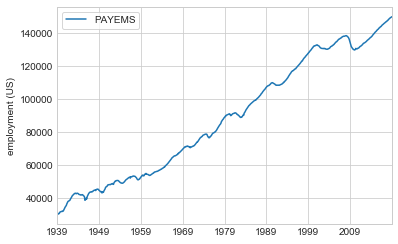

In [31]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

empl_us.plot(ax=ax)

ax.legend(frameon=True)
ax.set_xlabel('')
ax.set_ylabel('employment (US)');

## World Bank indicators: `wb`

**Finding data:**

1. go to https://data.worldbank.org/indicator/
2. search for GDP 
3. variable name ("NY.GDP.PCAP.KD") is in the URL

**Fetch GDP:**

In [32]:
from pandas_datareader import wb

In [33]:
wb_gdp = wb.download(indicator='NY.GDP.PCAP.KD', country=['SE','DK','NO'], start=1990, end=2017)
wb_gdp = wb_gdp.rename(columns = {'NY.GDP.PCAP.KD':'GDP'})
wb_gdp = wb_gdp.reset_index()
wb_gdp.head(5)

,country,year,GDP
0,Denmark,2017,62733.019808
1,Denmark,2016,61877.976481
2,Denmark,2015,60402.129248
3,Denmark,2014,59437.947322
4,Denmark,2013,58788.084162


In [34]:
wb_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  84 non-null     object 
 1   year     84 non-null     object 
 2   GDP      84 non-null     float64
dtypes: float64(1), object(2)
memory usage: 2.1+ KB


**Problem:** Unfortunately, it turns out that the dataframe has stored the variable year as an "object", meaning in practice that it is a string. Country is an object because it is a string, but that cannot be helped. Fortunately, GDP is a float (i.e. a number). Let's convert year to make it an integer:

In [35]:
wb_gdp.year = wb_gdp.year.astype(int)
wb_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  84 non-null     object 
 1   year     84 non-null     int32  
 2   GDP      84 non-null     float64
dtypes: float64(1), int32(1), object(1)
memory usage: 1.8+ KB


**Fetch employment-to-population ratio:**

In [36]:
wb_empl = wb.download(indicator='SL.EMP.TOTL.SP.ZS', country=['SE','DK','NO'], start=1990, end=2017)
wb_empl.rename(columns = {'SL.EMP.TOTL.SP.ZS':'employment_to_pop'}, inplace=True)
wb_empl.reset_index(inplace = True)
wb_empl.year = wb_empl.year.astype(int)
wb_empl.head(3)

,country,year,employment_to_pop
0,Denmark,2017,58.472000
1,Denmark,2016,59.400002
2,Denmark,2015,58.196999


**Merge:**

In [37]:
wb = pd.merge(wb_gdp, wb_empl, how='outer', on = ['country','year']);
wb.head(5)

,country,year,GDP,employment_to_pop
0,Denmark,2017,62733.019808,58.472000
1,Denmark,2016,61877.976481,59.400002
2,Denmark,2015,60402.129248,58.196999
3,Denmark,2014,59437.947322,57.994999
4,Denmark,2013,58788.084162,57.964001


# Split-apply-combine

One of the most useful skills to learn is **the split-apply-combine process**. For example, we may want to compute the average employment rate within a municipality over time and calculate whether the employment rate in each year is above or below the average. We calculate this variable using a split-apply-combine procedure: 

1. **split**: divide the dataset into units (one for each municipality)
2. **apply**: compute the average employment rate for each unit
3. **combine**: merge this new variable back onto the original dataset

## Groupby

**Example data:**

In [38]:
empl = empl.sort_values(['municipality','year']) # sort by first municipality then year
empl.head(5)

,municipality,year,e
68,Aabenraa,2008,74.6
167,Aabenraa,2009,71.6
266,Aabenraa,2010,70.9
365,Aabenraa,2011,70.2
464,Aabenraa,2012,69.5


Use **groupby** to calculate **within means**:

In [39]:
empl.groupby('municipality')['e'].mean().head(5)

municipality
Aabenraa       71.19
Aalborg        69.46
Aarhus         68.96
Albertslund    68.58
Allerød        81.37
Name: e, dtype: float64

**Custom functions** can be specified by using the `lambda` notation. E.g., average change:

In [40]:
empl.groupby('municipality')['e'].apply(lambda x: x.diff(1).mean()).head(5)

municipality
Aabenraa      -0.188889
Aalborg       -0.366667
Aarhus        -0.300000
Albertslund   -0.322222
Allerød       -0.177778
Name: e, dtype: float64

Or:

In [41]:
myfun = lambda x: np.mean(x[1:]-x[:-1])
empl.groupby('municipality')['e'].apply(lambda x: myfun(x.values)).head(5)

municipality
Aabenraa      -0.188889
Aalborg       -0.366667
Aarhus        -0.300000
Albertslund   -0.322222
Allerød       -0.177778
Name: e, dtype: float64

**Plot statistics**: Dispersion in employment rate across Danish municipalities over time.

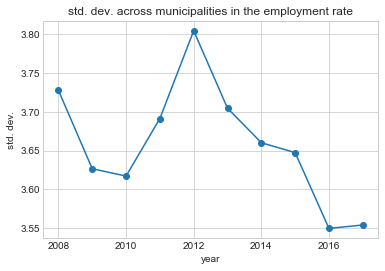

In [42]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

empl.groupby('year')['e'].std().plot(ax=ax,style='-o')

ax.set_ylabel('std. dev.')
ax.set_title('std. dev. across municipalities in the employment rate');

## Split-Apply-Combine

**Goal:** Calculate within municipality difference to mean employment rate.

**1. Split**:

In [43]:
e_grouped = empl.groupby('municipality')['e']

**2. Apply:**

In [44]:
e_mean = e_grouped.mean() # mean employment rate
e_mean.head(10)

municipality
Aabenraa       71.19
Aalborg        69.46
Aarhus         68.96
Albertslund    68.58
Allerød        81.37
Assens         72.03
Ballerup       72.78
Billund        76.53
Bornholm       67.32
Brøndby        68.71
Name: e, dtype: float64

Change name of series:

In [45]:
e_mean.name = 'e_mean' # necessary for join

**3. Combine:**

In [46]:
empl_ = empl.set_index('municipality').join(e_mean, how='left')
empl_['diff'] = empl_.e - empl_.e_mean
empl_.xs('Copenhagen')

,year,e,e_mean,diff
municipality,,,,
Copenhagen,2008,72.5,70.54,1.96
Copenhagen,2009,70.0,70.54,-0.54
Copenhagen,2010,69.7,70.54,-0.84
Copenhagen,2011,69.6,70.54,-0.94
Copenhagen,2012,69.4,70.54,-1.14
Copenhagen,2013,69.7,70.54,-0.84
Copenhagen,2014,70.0,70.54,-0.54
Copenhagen,2015,70.8,70.54,0.26
Copenhagen,2016,71.5,70.54,0.96


**Plot:**

Text(0, 0.5, 'difference to mean')

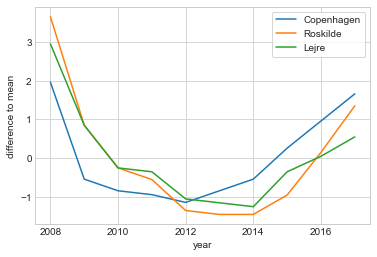

In [47]:
municipalities = ['Copenhagen','Roskilde','Lejre']

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for m in municipalities:
    empl_.xs(m).plot(x='year',y='diff',ax=ax,label=m)

ax.legend(frameon=True)
ax.set_ylabel('difference to mean')

### with `agg()`

**Agg:** The same value for all observations in a group.

In [48]:
empl_ = empl.copy()

# a. split-apply
e_mean = empl_.groupby('municipality')['e'].agg(lambda x: x.mean())
e_mean.name = 'e_mean'

# b. combine
empl_ = empl_.set_index('municipality').join(e_mean, how='left')
empl_['diff'] = empl_.e - empl_.e_mean
empl_.xs('Copenhagen')

,year,e,e_mean,diff
municipality,,,,
Copenhagen,2008,72.5,70.54,1.96
Copenhagen,2009,70.0,70.54,-0.54
Copenhagen,2010,69.7,70.54,-0.84
Copenhagen,2011,69.6,70.54,-0.94
Copenhagen,2012,69.4,70.54,-1.14
Copenhagen,2013,69.7,70.54,-0.84
Copenhagen,2014,70.0,70.54,-0.54
Copenhagen,2015,70.8,70.54,0.26
Copenhagen,2016,71.5,70.54,0.96


**Note:** Same result!!

### with - `transform()`

**Transform:** Different values across observations in a group.

In [49]:
empl_ = empl.copy()
empl_['diff'] = empl_.groupby('municipality')['e'].transform(lambda x: x - x.mean())
empl_.set_index('municipality').xs('Copenhagen')

,year,e,diff
municipality,,,
Copenhagen,2008,72.5,1.96
Copenhagen,2009,70.0,-0.54
Copenhagen,2010,69.7,-0.84
Copenhagen,2011,69.6,-0.94
Copenhagen,2012,69.4,-1.14
Copenhagen,2013,69.7,-0.84
Copenhagen,2014,70.0,-0.54
Copenhagen,2015,70.8,0.26
Copenhagen,2016,71.5,0.96


**Note:** Same result!!

### Need more complex stuff? 

Look [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html).

# Summary

**This lecture:** We have discussed

1. Combining datasets (**merging** and concatenating)
2. Fatching data using an **API** (DST, FRED, World Bank, etc.)
3. **Split-apply-combine** (groupby, agg, transform)

**Your work:** Before solving Problem Set 4 read through this notebook and play around with the code.

**Project 1:** See the details under *Project 1: Data analysis* [here](https://numeconcopenhagen.netlify.com/exercises/).<br>
**Deadline:** 6th of April.

**Next lecture:** Algorithms: Searching and sorting algorithms.